![STScI Logo](../../../_static/stsci_header.png)

<a id="topF"></a>

# Filtering out COS Data taken during the Day or Night

## Learning Goals
<font size="4 "> This Notebook is designed to walk the user (<em>you</em>) through: <b>Filtering Cosmic Origins Spectrograph (<em>COS</em>) `TIME-TAG` data taken during the day from data taken during the night</b>:</font>
    
**1. [Processing a spectrum from a filtered dataset](#procF)**

\- 1.1. [Filtering the `TIME-TAG` data](#filtF)

\- 1.2. [Creating a new association file](#asnF)

\- 1.3. [Running the `CalCOS` pipeline on the filtered dataset](#CalCOSF)

**2. [Comparing the filtered and unfiltered data](#compF)**

## 0. Introduction and Setup
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**This tutorial aims to prepare you to work with the COS data of your choice by walking you through filtering `TIME-TAG` datapoints obtained by COS.**

In particular, this tutorial will walk you through separating datapoints obtained during the Hubble Space Telescope's "night" - when the sun is below the geometric horizon from the observatory's point of view - from datapoints taken during the observatory's "day" - when the sun is above this horizon. 
You may wish to disaggregate photons from these two time periods, as data taken during the day can be subject to different and higher background noise conditions, as well as more intense geocoronal Lyman-alpha or Oxygen-I emission lines from the Earth’s atmosphere ([See Data Handbook 5.4.2](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data#id-5.4WorkingwithTIMETAGData-5.4.2FilteringTime-TagData:~:text=same%20as%20above.-,5.4.2%20Filtering%20Time%2DTag%20Data,-Filtering%20Events%20in)).
This type of data separation is possible with the [`TIME-TAG` data](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) obtained by the COS photon-counting detectors, because each individual encounter with a photon is recorded with its own metadata such as the time of the encounter, and can be linked to the physical position of Hubble at that time. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

### We will import the following packages:

- `costools timefilter` to select `TIME-TAG` datapoints by their metadata parameters
- `calcos` to re-process the data
- `numpy` to handle array functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `glob` and `os` for working with system files
- `matplotlib.pyplot` and `gridspec` for plotting data
- `astroquery.mast Mast` and `Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/search/ui/#/hst) archive
- `pathlib Path` for managing system paths

New versions of `CalCOS` are currently incompatible with astroconda. To create a Python environment capable of running all the data analyses in these COS Notebooks, please see Section 1 of our Notebook tutorial on [setting up an environment](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb).

In [1]:
# Import for: filtering TIME TAG data i.e. by sun altitude
from costools import timefilter

# Import for: processing COS data
import calcos 

# Import for: array manipulation
import numpy as np

# Import for: reading FITS files
from astropy.io import fits                                            
from astropy.table import Table

# Import for: dealing with system files
import glob
import os

# Import for: plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Import for: downloading the data
from astroquery.mast import Observations

# Import for: working with system paths
from pathlib import Path

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/costools/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


### We will also define a few directories we will need:

In [2]:
# These will be important directories
datadir = Path('./data')
outputdir = Path('./output/')
intermediate_dir = Path('./intermediate/')
plotsdir = Path('./output/plots')

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True)
outputdir.mkdir(exist_ok=True)
plotsdir.mkdir(exist_ok=True)
intermediate_dir.mkdir(exist_ok=True)

### And we will need to download the data we wish to filter and analyze
We choose the exposure with obs_id: `lbry01i6q`, because we happen to know it contains data taken both in the observatory's night and day and shows strong airglow lines. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

In [3]:
filename_root = 'lbry01i6q'

# Create product list of all observations with that obs_id root
pl = Observations.get_product_list(
            Observations.query_criteria(
                proposal_id='12604',
                obs_id='lbry01*'))

# Create a mask with only the corrtag files
pl_mask = ((pl['productSubGroupDescription'] == "CORRTAG_A")
           | (pl['productSubGroupDescription'] == "CORRTAG_B"))\
            & (pl['obs_id'] == filename_root)

# Download those corrtag files
Observations.download_products(pl[pl_mask],
                               download_dir=str(datadir))

file_locations_orig = glob.glob('./data/**/*corrtag*.fits',
                                recursive=True)

for file_orig in file_locations_orig:
    # Aggregates the data from out of long convoluted filepaths
    # NOTE: can cause problems if you have non-unique filenames
    os.rename(file_orig,
              './data/'+os.path.basename(file_orig))

# Finds all the FUVA and FUVB files
file_locations_a = glob.glob('./data/**/*corrtag_a.fits',
                             recursive=True)
file_locations_b = glob.glob('./data/**/*corrtag_b.fits',
                             recursive=True)

 [Done]


 [Done]


<a id = procF></a>
## 1. Processing a spectrum from a filtered dataset

<a id = filtF></a>
### 1.1. Filtering the `TIME-TAG` data
The `costools` package contains the `TimelineFilter` class, which - upon instantiation - filters by the parameters you give it. In other words, you don't have to run any functions or methods aside from instantiating the class. This is done by passing the following parameters to `timefilter.TimelineFilter`:
- `input`: the path to the input `TIME-TAG` file. (string)
- `output`: the path to the output `TIME-TAG` file. (string)
- `filter`: a comparison filter (see examples below). Data points who meet the filter criteria will be *filtered out* by turning on their "bad time interval" data quality flag. (string)

Only `TIME-TAG` data has the timing data necessary to be processed using `timefilter`. We must first ensure that all the data we wish to process is `TIME-TAG` data:

In [4]:
def check_time_tag(filepath):
    """
    Function which yields descriptive errors if the input file is not a COS TIME-TAG file.
    Inputs: 
      filepath (str): path to your data
    """
    instrume = fits.getval(filepath, keyword='INSTRUME'), 
    imagetyp = fits.getval(filepath, keyword='IMAGETYP')
    
    assert instrume[0] == 'COS', "DataTypeError: Files not from COS"
    assert imagetyp == 'TIME-TAG', "DataTypeError: Files not TIME-TAG. Cannot process with timefilter."


for file in (file_locations_a + file_locations_b):
    check_time_tag(file)

<font size="4"> Below, we will filter by the sun's altitude above the geometric horizon from the point-of-view of the Hubble Observatory. <b>Daytime</b> is whenever this altitude is greater than 0 degrees.</font>

The filtering parameters are explained in the [Section 5.4.2 of the COS Data Handbook: Filtering Time-Tag Data](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data#id-5.4WorkingwithTIMETAGData-5.4.2FilteringTime-TagData:~:text=same%20as%20above.-,5.4.2%20Filtering%20Time%2DTag%20Data,-Filtering%20Events%20in). 

*All of the available filters are*:

|Property|Variable name|
|-|-|
|Time of photon encounter \[32 ms bins\]|`time`|
|Observatory latitude/longitude|`longitude`/`latitude`|
|Sun's altitude|`sun_alt`|
|Observing target's current altitude|`target_alt`|
|Radial velocity of HST towards target|`radial_vel`|
|Shift along dispersion axis|`shift1`|
|Total $\frac{counts}{sec}$ in a box across the aperture about $Ly_\alpha$|`ly_alpha`|
|Total $\frac{counts}{sec}$ in a box across the aperture about $O I 1304$|`oi_1304`|
|Total $\frac{counts}{sec}$ in a box across the aperture about $O I 1356$|`oi_1356`|
|Detector dark current rate|`darkrate`|


... or any combination of these filters. There is one more filter keyword which behaves slightly differently: `saa`. By specifying `saa <n>` where $0\le n \le 32$, you can exclude the $n^{th}$ model contour of the [South Atlantic Anomaly (SAA)](https://en.wikipedia.org/wiki/South_Atlantic_Anomaly) as modeled by `costools.saamodel`.

The following comparison operators are allowed:

|Symbol|Example|Meaning ("Filter *out* points taken when...")|
|-|-|-|
|`==`|`time == 0`|Time of photon interaction is equal to 0 seconds|
|`!=`|`longitude != 3`|HST's longitude is not equal to 3˚|
|`<=`|`sun_alt >= 0`|Sun's altitude is greater than or equal to 0˚|
|`>=`|`target_alt <= 90`|Target's altitude is less than or equal to 90˚|
|`<`|`radial_vel < 0.1`|Radial velocity of HST towards target is less than 10 $\frac{km}{s}$|
|`>`|`ly_a > 5`|Total $\frac{counts}{sec}$ in a box across the aperture about $Ly_\alpha$ is greater than 5 $\frac{counts}{sec}$|
||||
|***Combination***|`oi_1304 > 100 AND sun_alt <= 10 OR target_alt < 30`|Total irradiance about 1304 Å is greater than 100 *AND* the Sun's altitude is less than or equal to 10˚ *OR* the target's altitude is below 30˚|

*Note* that in the combination example above, the *"OR"* takes precedence over "AND". If a count does not satisfy both of the first 2 statements, but it does satisfy statement 3, it will be considered to meet the filter, its "bad time interval" data quality flag will be turned on, and it will not be allowed to contribute to the output spectrum.

*Note* also that the `TimelineFilter` class will not overwrite existing files, so if you wish to filter the files using the following code more than once, you must delete the files you have already created in the `intermediate` directory. To ease this process, the first several lines in the following cell attempt to delete any previously created files.

In [5]:
# If the files already exist, delete them so you may run the filter again
# Check if you have created a filtered FUVA file:
if (intermediate_dir / "filtered_corrtag_a.fits").exists():
    print(f"File exists; deleting {intermediate_dir / 'filtered_corrtag_a.fits'}\n")
    # If so, delete the file so we can re-create it with TimelineFilter
    (intermediate_dir / "filtered_corrtag_a.fits").unlink()

# Repeat the check-delete process above with FUVB file:
if (intermediate_dir / "filtered_corrtag_b.fits").exists():
    print(f"File exists; deleting {intermediate_dir / 'filtered_corrtag_b.fits'}\n")
    (intermediate_dir / "filtered_corrtag_b.fits").unlink()

# Filter the files based on your criteria
# This must be repeated for all exposure files, so both FUVA and FUVB
for afile, bfile in zip(file_locations_a, file_locations_b):
    timefilter.TimelineFilter(input=afile,
                              # Run TimelineFilter on FUVA file
                              output=str(intermediate_dir / "filtered_corrtag_a.fits"),
                              # Removes daytime data, where the Sun's altitude above horizon is 0 degrees
                              filter="sun_alt > 0.",
                              verbose=True)

    timefilter.TimelineFilter(bfile,
                              # Run TimelineFilter on FUVB file
                              str(intermediate_dir / "filtered_corrtag_b.fits"),
                              "sun_alt > 0.")

File exists; deleting intermediate/filtered_corrtag_a.fits

File exists; deleting intermediate/filtered_corrtag_b.fits

Input file /home/runner/work/hst_notebooks/hst_notebooks/notebooks/COS/DayNight/data/lbry01i6q_corrtag_a.fits
sun_alt > 0. flagged as bad
EXPTIME changed from 1176.192 to 137.18394
New GTI extension appended
Writing to /home/runner/work/hst_notebooks/hst_notebooks/notebooks/COS/DayNight/intermediate/filtered_corrtag_a.fits


<a id = asnF></a>
### 1.2. Creating a new association file
In order to run the `CalCOS` pipeline on your newly filtered data, an association (`asn`) file must be made, instructing the pipeline where to look for the filtered `TIME-TAG` data files. Association files, (and how to create and edit them,) are discussed in detail in our [Notebook Tutorial on Association Files](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/AsnFile/AsnFile.ipynb).

In the next cells, we build **two** new association files from scratch:
1. For these new **filtered** files
2. For the original **unfiltered** files, so that we can compare and see the effect of filtering. 

In [6]:
# First, create asn for the newly filtered-by-sun_alt files (this and next cell):
# This dict properly assigns the type of exposure in a way that CalCOS will recognize
type_dict = {'WAVECAL': 'EXP-AWAVE',
             'EXTERNAL/SCI': 'EXP-FP'}

# Finds all the corrtag_a (just FUVA) files downloaded above
files = glob.glob(str(intermediate_dir/"*_corrtag_a.fits"))

***Note* that the above cell only found the segment A files** (i.e. from the COS FUVA detector.) You only need the A segment in the ASN, and CalCOS will find the associated B segment data for you, if the files are in the same directory.

We can now build the `asn` file:

In [7]:
for f in files:    
    # Adding the file details to the association table
    # MEMNAME:
    rootnames = [f]
    # MEMTYPE:
    types = [type_dict[fits.getval(f, 'EXPTYPE')]]
    # MEMPRSNT
    included = [True]
    
    # Adding the ASN details to the end of the association table
    # the rootname needs to be the full name, not just the rootname:
    # Remove the extra "_" at the end of string
    asn_root = os.path.basename(f.split('corrtag')[0][:-1])
    # MEMNAME:
    rootnames.append(asn_root.upper())
    # MEMTYPE:
    types.append('PROD-FP')
    # MEMPRSNT
    included.append(True)
    
    # Putting together the FITS table
    # 40 is the number of characters allowed in this '40A' field.
    # If your rootname is longer than 40, you will need to increase this
    c1 = fits.Column(name='MEMNAME',
                     array=np.array(rootnames),
                     format='40A')
    c2 = fits.Column(name='MEMTYPE',
                     array=np.array(types),
                     format='14A')
    c3 = fits.Column(name='MEMPRSNT',
                     format='L',
                     array=included)

    t = fits.BinTableHDU.from_columns([c1, c2, c3])

    # Writing the FITS table
    t.writeto(asn_root.lower()+'_asn.fits',
              overwrite=True)

    print('Saved: {}'.format(asn_root.lower()+'_asn.fits'), "in cwd")

Saved: filtered_asn.fits in cwd


We can see the contents of this new association file below:

In [8]:
Table.read("filtered_asn.fits")

MEMNAME,MEMTYPE,MEMPRSNT
bytes40,bytes14,bool
intermediate/filtered_corrtag_a.fits,EXP-FP,True
FILTERED,PROD-FP,True


*Note* that in the "MEMNAME" column, we define the location of the corrtag file we wish to process in terms of a local path (the path from the current working directory from which we run our code to the file in the `intermediate` directory.) It is also possible to simply give the "MEMNAME" column the file's rootname (i.e `filtered_corrtag_a`) as long as this file and the association files are in the same directory.

In [9]:
# In this cell, we make an association file for the unfiltered data files:
for f in file_locations_a:
    # Adding the file details to the association table
    # MEMNAME:
    rootnames = [f]
    # MEMTYPE
    types = [type_dict[fits.getval(f, 'EXPTYPE')]]
    # MEMPRSNT
    included = [True]

    # Adding the ASN details to the end of the association table:
    # The rootname needs to be full name, not just the rootname
    # Removing the extra "_" at end of string
    asn_root = os.path.basename(f.split('corrtag')[0][:-1])
    # MEMNAME:
    rootnames.append(asn_root.upper())
    # MEMTYPE
    types.append('PROD-FP')
    # MEMPRSNT
    included.append(True)
    
    # Putting together the FITS table
    c1 = fits.Column(name='MEMNAME',
                     array=np.array(rootnames),
                     format='40A') 
    c2 = fits.Column(name='MEMTYPE',
                     array=np.array(types),
                     format='14A')
    c3 = fits.Column(name='MEMPRSNT',
                     format='L',
                     array=included)

    t = fits.BinTableHDU.from_columns([c1, c2, c3])
    
    # Writing the FITS table
    t.writeto(asn_root.lower()+'_asn.fits',
              overwrite=True)

    print('Saved: {}'.format(asn_root.lower()+'_asn.fits'), "in cwd")

Saved: lbry01i6q_asn.fits in cwd


Again, we can see the contents of this association file below:

In [10]:
Table.read(f"{filename_root}_asn.fits")

MEMNAME,MEMTYPE,MEMPRSNT
bytes40,bytes14,bool
./data/lbry01i6q_corrtag_a.fits,EXP-FP,True
LBRY01I6Q,PROD-FP,True


<a id = CalCOSF></a>
### 1.3. Running the `CalCOS` pipeline

Now we need to reduce the data using the `CalCOS` pipeline. If you have not already checked out our tutorial on [Running the `CalCOS` pipeline](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/CalCOS/CalCOS.ipynb), it contains vital information and is *highly recommended*.

<hr>
<font size="4 ">[If you have not yet downloaded the files as in Section 3 of "Setup.ipynb", click to skip this cell](#skipcellF)</font>

<font size="4 ">If you ran <a href="https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb">Section 3 of our Notebook on "Setting up your environment"</a>, you likely do not need to download more reference files. </font>

You can instead simply point to the reference files you downloaded, using the `crds bestrefs` command, as shown in the following three steps. Run these steps from your command line *if and only if* you already have the reference files in a local cache.

**1**. The following sets environment variable for crds to look for the reference data online:

```$ export CRDS_SERVER_URL=https://hst-crds.stsci.edu``` 

**2**. The following tells crds where to save the files it downloads - set this to the directory where you saved the crds_cache as in [Section 3 of our Notebook on "Setup"](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb):

```$ export CRDS_PATH=${HOME}/crds_cache```

**3**. The following will update the data files you downloaded so that they will be processed with the reference files you previously downloaded. 

> *Note that these reference files are continually updated and for documentation and to find the newest reference files, see the [CRDS website](https://hst-crds.stsci.edu).*

```$ crds bestrefs --files data/*.fits --update-bestrefs --new-context '<the imap or pmap file you used to download the reference files>'```



Assuming everything ran successfully, you can now [skip the next several cells to running the pipeline](#runC).

<hr>


<a id=skipcellF></a>

<font size="4"> If you have not yet downloaded the reference files, you will need to do so, as shown below:</font>
    
Unless we are connected to the STScI network, or already have the reference files on our machine, we will need to download the reference files and tell the pipeline where to look for the flat files, bad-pixel files, etc.

<font size="4 "> Caution!</font>

<img src=figures/warning.png width ="60" title="CAUTION!"> 

**The process in the following two cells can take a long time and strain network resources!** If you have already downloaded *up-to-date* COS reference files, avoid doing so again.
    
Instead, keep these crds files in an accessible location, and point an environment variable `lref` to this directory. For instance, if your lref files are on your username's home directory, in a subdirectory called `crds_cache`, give Jupyter the following command then skip the next 2 cells:

```%env lref /Users/<your username>/crds_cache/references/hst/cos/```

**Again, only run the following two cells if you have not downloaded these files before:**
In the next two cells, we will setup an environment of reference files, download the files, and save the output of the crds download process in a log file:

In [11]:
%%capture cap --no-stderr

%env lref ./data/reference/references/hst/cos/
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env CRDS_PATH ./data/reference/

# The next line depends on your context and pmap file
# You can find the latest pmap file at https://hst-crds.stsci.edu
!crds bestrefs --files **/*corrtag*.fits  --sync-references=2 --update-bestrefs --new-context 'hst_1123.pmap'

In [12]:
# This file now contains the output of the last cell
with open(str(outputdir/'crds_output_1.txt'), 'w') as f:
    f.write(cap.stdout)

<a id=runC></a>

<font size="4 "> <b>And now, to run the pipeline itself:</b></font>

Again, *because we wish to compare against the unfiltered data*, we must run the pipeline twice:
1. For these new **filtered** files
2. For the original **unfiltered** files, so that we can compare and see the effect of filtering. 

*You can ignore any `AstropyDeprecationWarning`s that pop up*

In [13]:
%%capture cap --no-stderr
# First, run with "filtered" data with only time-tag datapoints allowed by filter
try:
    calcos.calcos('./filtered_asn.fits',
                  outdir=str(outputdir / "filtered_data_outs"),
                  verbosity=0)
except RuntimeError as e:
    print('An error occured', e)

In [14]:
%%capture cap --no-stderr
# Now, run CalCOS with the initial "full" data - with all time-tag datapoints
try:
    calcos.calcos(f'./{filename_root}_asn.fits',
                  outdir=str(outputdir / "full_data_outs"),
                  verbosity=0)
except RuntimeError as e:
    print('An error occured', e)

<a id = compF></a>
## 2. Comparing the filtered and unfiltered data
**Excellent!** We're essentially done at this point. 

Let's read in both of the processed spectra (the `x1dsum` files) and plot the spectra against one another.

*You can ignore any `UnitsWarning`s that pop up about formatting.*

In [15]:
# Read in the wvln, flux, flux error of the *UNfiltered* spectrum file
unfilt_tab = Table.read(f"./output/full_data_outs/{filename_root}_x1dsum.fits")['WAVELENGTH', 'FLUX', 'ERROR']

# Read in the wvln, flux, flux error of the *filtered* spectrum file
filt_tab = Table.read("./output/filtered_data_outs/filtered_x1dsum.fits")['WAVELENGTH', 'FLUX', 'ERROR']

# Convert to dict and combine segments
combo_dict_f = {'WAVELENGTH': [], 'FLUX': [], 'ERROR': []}
combo_dict_u = {'WAVELENGTH': [], 'FLUX': [], 'ERROR': []}

# Reverse segments FUVA and B for filtered data
for row in filt_tab[::-1]:
    for key in row.colnames:
        combo_dict_f[key] += (list(row[key]))

# Reverse segments FUVA and B for UNfiltered data
for row in unfilt_tab[::-1]:
    for key in row.colnames:
        combo_dict_u[key] += (list(row[key]))

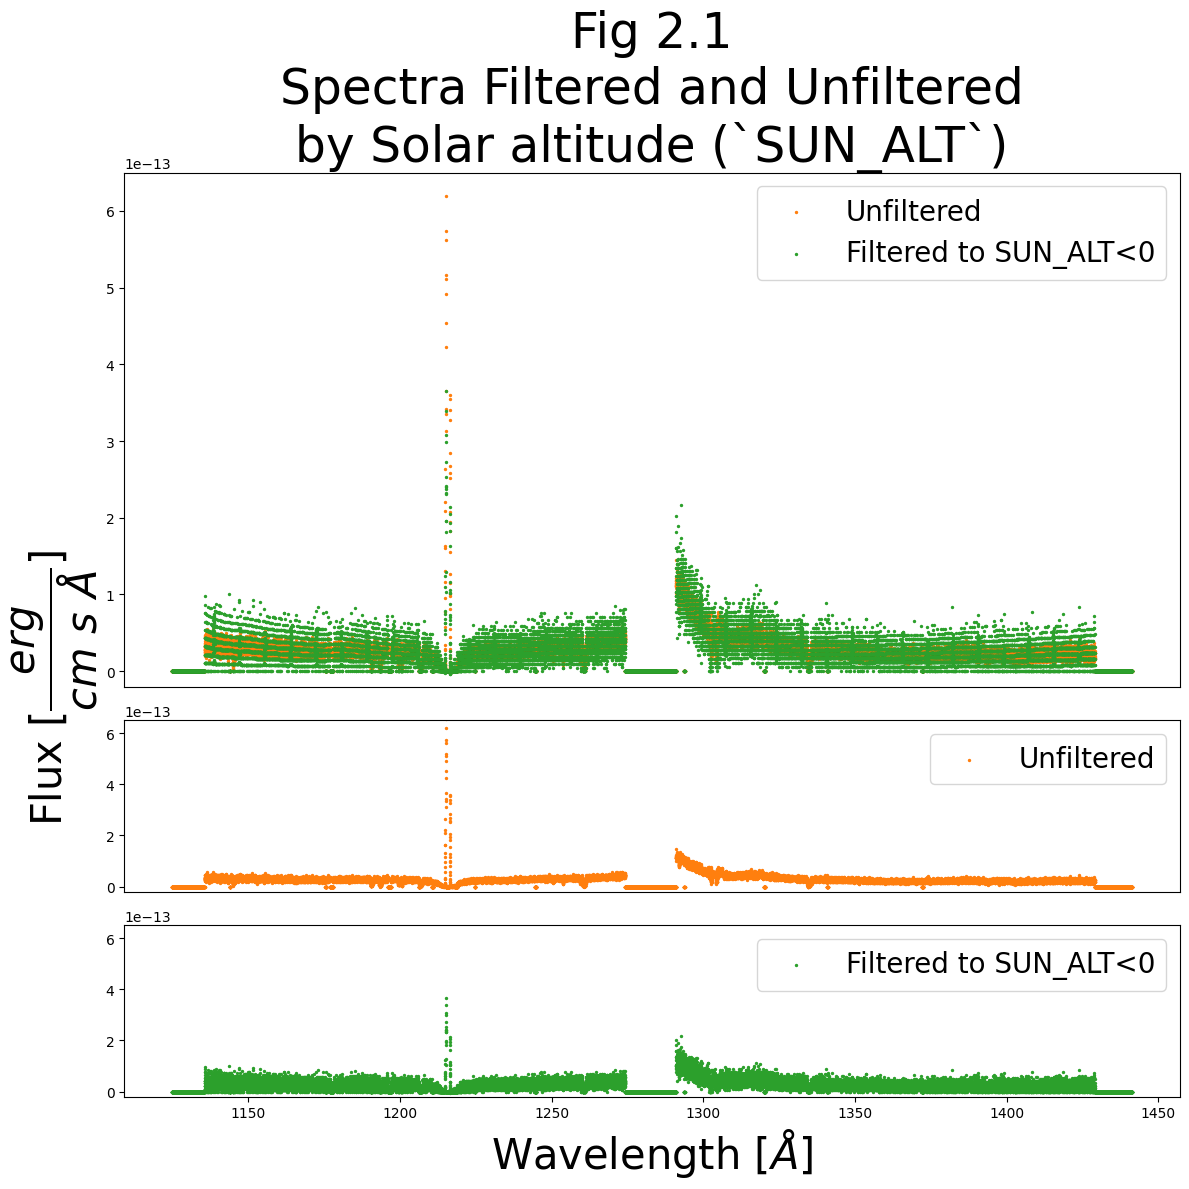

In [16]:
# Set up the figure with subplots:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 1,
                       height_ratios=[3, 1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# Plot the data in 3 subplots
ax0.scatter(combo_dict_u["WAVELENGTH"],
            combo_dict_u["FLUX"],
            s=2,
            alpha=1,
            c='C1',
            label="Unfiltered")

ax0.scatter(combo_dict_f["WAVELENGTH"],
            combo_dict_f["FLUX"],
            s=2,
            alpha=1,
            c='C2',
            label="Filtered to SUN_ALT<0")

ax1.scatter(combo_dict_u["WAVELENGTH"],
            combo_dict_u["FLUX"],
            s=2,
            alpha=1,
            c='C1',
            label="Unfiltered")

ax2.scatter(combo_dict_f["WAVELENGTH"],
            combo_dict_f["FLUX"],
            s=2,
            alpha=1,
            c='C2',
            label="Filtered to SUN_ALT<0")

# Format the figure
ax0.set_xticks([])
ax1.set_xticks([])

ax0.legend(fontsize=20)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)

ax0.set_ylim(-2E-14, 6.5E-13)
ax1.set_ylim(-2E-14, 6.5E-13)
ax2.set_ylim(ax1.get_ylim())

ax0.set_title("Fig 2.1\nSpectra Filtered and Unfiltered\nby Solar altitude (`SUN_ALT`)",
              size=35)

ax0.set_ylabel(r"Flux [$\dfrac{erg}{cm\ s\ \AA}$]", 
               fontsize=30,
               y=0.0,
               horizontalalignment='center')

ax2.set_xlabel(r"Wavelength [$\AA$]",
               fontsize=30)

plt.tight_layout()

plt.savefig(str(plotsdir / 'compare_spectra_sunalt.png'),
            dpi=300)

**We can see that the filtered spectrum largely follows the unfiltered spectrum; however, we significantly reduce the Lyman-alpha light from airglow around 1215 Å.**

Because we filter out many of the datapoints used to calculate the spectrum, we can see a significant reduction in precision in flux space (visible as a **banding** in the y-axis). This can come about because with few datapoints, the bands represent wavelengths which received (0,1,2...n) discrete photons. The banding can sometimes be more pronounced at longer, redder wavelengths. 

**Below, let's make one final plot: a segment of the spectrum around Lyman-alpha (\~1215 Å) showing the errors in flux:**

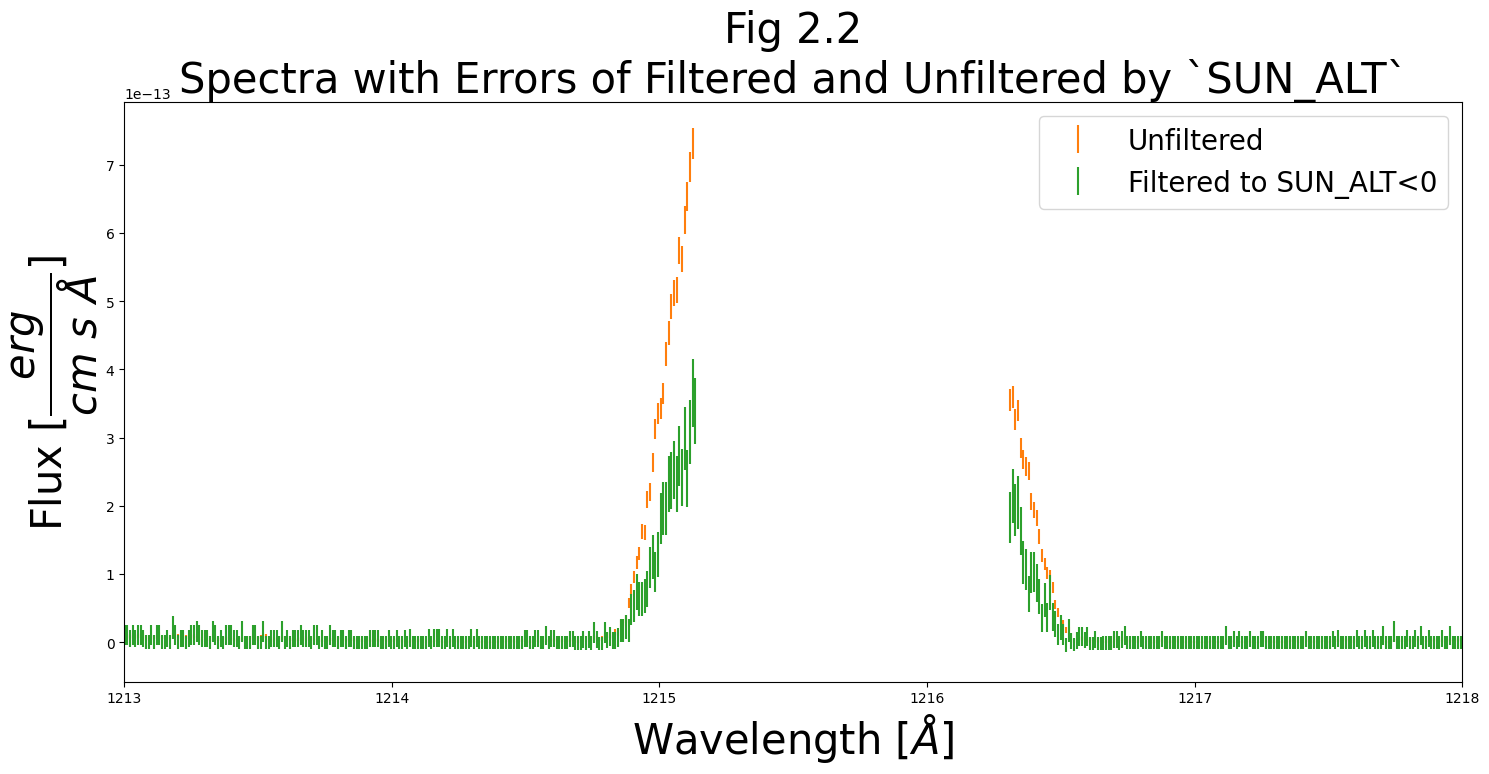

In [17]:
fig, (ax0) = plt.subplots(
             nrows=1,
             ncols=1,
             figsize=(15, 8))

ax0.errorbar(combo_dict_u["WAVELENGTH"],
             combo_dict_u["FLUX"],
             combo_dict_u["ERROR"], 
             linestyle='',
             markersize=2,
             alpha=1,
             c='C1',
             label="Unfiltered")

ax0.errorbar(combo_dict_f["WAVELENGTH"],
             combo_dict_f["FLUX"],
             combo_dict_f["ERROR"], 
             linestyle='',
             markersize=2,
             alpha=1,
             c='C2',
             label="Filtered to SUN_ALT<0")

ax0.legend(fontsize=20)

ax0.set_xlabel(r"Wavelength [$\AA$]",
               fontsize=30)
ax0.set_ylabel(r"Flux [$\dfrac{erg}{cm\ s\ \AA}$]",
               fontsize=30,
               horizontalalignment='center')
ax0.set_title("Fig 2.2\nSpectra with Errors of Filtered and Unfiltered by `SUN_ALT`",
              size=30)

ax0.set_xlim(1213, 1218)

plt.tight_layout()

plt.savefig(str(plotsdir / 'ebar_compare_spectra_sunalt.png'),
            dpi=300)



**With substantially fewer datapoints, our filtered dataset has larger errors.**

We can, however, understand why we might want to filter by this, or another `sun_alt` filter. For instance, if most of your exposure was taken at night, but the last 10% was taken after the sun had risen and induced an atmospheric line which interferes with your data, it would often be necessary to filter out this last 10% of the exposure.

## In conclusion
* We have learned how to use `costools.timefilter` to separate data taken during HST's day from data taken during the observatory's night
* We have discussed the benefits of using this method to remove light from Earth's upper atmosphere, as well as the associated loss in signal-to-noise ratio that comes from shortening the effective exposure time.

## Congratulations! You finished this Notebook!
<font size="5">There are more COS data walkthrough Notebooks on different topics. You can find them <a href="https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS">here</a>.</font>

---
## About this Notebook
**Author:** Nat Kerman

**Curator:** Anna Payne apayne@stsci.edu

**Contributors:** Elaine Mae Frazer

**Updated On:** 2023-12-05

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing`matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

<hr>

[Top of Page](#topF)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>